<font color="#CA3532" style="font-size:40px"><h1 align="left" >Análisis y visualización del dataset</h1></font>
<font color="#6E6E6E"><h3 align="left">Jaen-Lorites, Jose Manuel</h3></font> 

En este documento se pretende tomar un primer contacto con el dataset, entender su estructura, y realizar algunas comprobaciones básicas.

## Índice:
1. [Importación de librerias básicas](#librerias)
2. [Manejo del dataset y las imágenes](#dataset-imagenes)  
    2.1. [Estructura de data](#data-structure)  
    2.2. [Visualización de data](#data-visualization)

## 1. Importación de librerias básicas <a class="anchor" id="librerias"></a>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd

plt.rcParams['image.cmap'] = 'gray' # Set default colormap as gray  

import tensorflow as tf
from tensorflow.keras import backend as K

import os
import time


if not ("path_list" in globals()): # Comprobamos que path_list está cargado, y lo cargamos si no
    path_list = pd.read_pickle("../data/path_list.pkl")
    labels = path_list.label.unique()
    split = path_list.split.unique()
    image_type = path_list.image_type.unique()
    file_npy = path_list.file_npy.unique()
if not ("df_metadata_images" in globals()): # Comprobamos que path_list está cargado, y lo cargamos si no
    df_metadata_images = pd.read_pickle("../data/df_metadata_images.pkl")

## 2. Manejo del dataset y las imágenes <a class="anchor" id="dataset-imagenes"></a>

*TODO:*
- Create a function to load data
- Put as argument the number of images to load (to get small subsets to perform the net tests)
- Maybe will not be possible to load all data at once. Search how to proceed
- Create a DataFrame with the image path and the image label
- Maybe another DataFrame with the metadata (i.e. images per class)

Creamos una función que nos lea todos los directorios, y nos cree un dataset con los path de todos los archivos. Este dataset lo vamos a guardar en formato pickle y lo vamos a almacenar. De esta forma, podremos cargar las diferentes imágenes en función de la etiqueta o búsqueda que querramos, sin tener que estar modificando bucles y funciones. Se guarda en picke para no tener que crear el dataset cada vez, y que sea rápido de cargar. 

No es necesario volver a ejecutar.

**ID unico por paciente**

In [4]:
def create_df_paths_images(dataset_path = "D:/Dicom_organized"):
    df = pd.DataFrame() #columns = ["label", "split", "image_type", "file_npy", "file_path"]
    dict_data={}
    sep = "/"
    subcarpetas1 = ["training", "test", "validation"]
    subcarpetas3 = ["raw","resampled"] # Omitimos seg
    carpetas = os.listdir(dataset_path)
    for carpeta in carpetas:
        dict_data["label"] = carpeta
        for subcarpeta1 in subcarpetas1:
            dict_data["split"] = subcarpeta1
            path_aux = sep.join((dataset_path,carpeta,subcarpeta1))
            subcarpetas2 = os.listdir(path_aux)
            for subcarpeta2 in subcarpetas2:
                dict_data["id"] = subcarpeta2
                for subcarpeta3 in subcarpetas3:
                    dict_data["image_type"] = subcarpeta3
                    files_npy = os.listdir(sep.join((path_aux,subcarpeta2, subcarpeta3)))
                    for file_npy in files_npy:
                        dict_data["file_npy"] = file_npy.split(".")[0]
                        dict_data["file_path"] = sep.join((path_aux,subcarpeta2, subcarpeta3, file_npy))
                        df = df.append(dict_data, ignore_index=True)
    return(df)
                              
path_list = create_df_paths_images()
path_list.to_pickle("../data/path_list.pkl")

In [5]:
path_list

,file_npy,file_path,id,image_type,label,split
0,cine,D:/Dicom_organized/both_only/training/10890674...,10890674_27052016,raw,both_only,training
1,diastole_data,D:/Dicom_organized/both_only/training/10890674...,10890674_27052016,raw,both_only,training
2,segmented,D:/Dicom_organized/both_only/training/10890674...,10890674_27052016,raw,both_only,training
3,sistole_data,D:/Dicom_organized/both_only/training/10890674...,10890674_27052016,raw,both_only,training
4,time_series_data,D:/Dicom_organized/both_only/training/10890674...,10890674_27052016,raw,both_only,training
...,...,...,...,...,...,...
4791,diastole_data,D:/Dicom_organized/RV_plus/validation/2173519_...,2173519_08082018,resampled,RV_plus,validation
4792,segmented_resampled,D:/Dicom_organized/RV_plus/validation/2173519_...,2173519_08082018,resampled,RV_plus,validation
4793,sistole_data,D:/Dicom_organized/RV_plus/validation/2173519_...,2173519_08082018,resampled,RV_plus,validation
4794,time_series_data,D:/Dicom_organized/RV_plus/validation/2173519_...,2173519_08082018,resampled,RV_plus,validation


Creamos ahora una función que obtenga un dataset con los metadatos de todas las imágenes. Esto nos puede ser muy útil para asegurarnos que todas las imágenes son como esperamos.

In [3]:
# Dado que vamos a trabajar con resampled, analizamos esas directamente, concretamente sistole y diastole

def create_df_metadata_images(path_list = path_list):
    df_metadata = pd.DataFrame()
    df_paths = get_df_paths(n = 0, file_npy = ["diastole_data", "sistole_data"])
    for idx,row in df_paths.iterrows():
        try:
            image = np.load(row["file_path"], allow_pickle = True)[0]
            row["image_shape"] = image.shape
            row["image_shape_x"] = image.shape[0]
            row["image_shape_y"] = image.shape[1]
            row["image_shape_z"] = image.shape[2]
            row["image_type"] = image.dtype
            row["image_min"] = image.min()
            row["image_max"] = image.max()
            row["image_mean"] = image.mean()
            row["image_std"] = image.std()
        except FileNotFoundError:
            print("PATH NOT FOUND:",row["file_path"])
        
        df_metadata = df_metadata.append(row, ignore_index = True)
    return(df_metadata)
        
df_metadata_images = create_df_metadata_images()
df_metadata_images.to_pickle("../data/df_metadata_images.pkl")

In [4]:
# 2 Carpetas no tienen sistole:

ids = df_metadata_images["id"]
ids_no_sistole = ids.isin(df_metadata_images.id[df_metadata_images["file_npy"]=="sistole_data"])
df_metadata_images.id[~ids_no_sistole]

49    288582_05042017
71    228754_05102017
Name: id, dtype: object

In [10]:
np.sum(df_metadata_images["file_npy"]=="sistole_data")

398

A continuación dos funciones que nos van a ser muy importantes.   

La primera de ellas nos va a devolver un dataframe con aquellas filas que contengan unos valores que le pasaremos como argumento a la función. Ésta nos devolverá un dataframe con n filas a partir del dataframe pl que le pasemos, pudiendo indicar que las n filas sean o no aleatorias.  

La segunda función tiene como argumento la salida de la función anterior. Ésta va a ser la encargada de cargar el conjunto de imágenes deseadas, las cuales devolverá en una lista. 

*Para acceder a un corte: images[ 0 ] [:, :, X]*

In [2]:
# n = 0 -> all possible index
# else, n -> nº of index to get
def get_df_paths(pl = path_list, n=1, random = True, labels = labels, 
                 split = split, image_type = ["resampled"], file_npy = ["sistole_data"]):
#   Cogemos los índices de las imagenes deseadas
    idx = np.array(True)
    args = {"label":labels, "split":split , "image_type":image_type , "file_npy":file_npy}
    for nombre in args.keys():
        lista = args[nombre]
        pattern = '|'.join(lista)
        idx_aux = pl[nombre].str.contains(pattern)
        idx = idx & idx_aux
    pl = pl[idx]
    len_pl = idx.sum()
    if n==0:
        n = len_pl
    # Seleccionamos n filas
    if random:
        idx = rd.sample(range(len_pl), n)
    else:
        idx = np.arange(n)
    return(pl.iloc[idx])
    
def load_images(df_paths, output_list=False, move_axis=True):
    if output_list:
        images = list()
        for file_path in df_paths["file_path"]:
            images.append(np.load(file_path, allow_pickle=True)[0])
        return (images)
    else:
        images = np.empty(shape=[180, 180, 1])
        for file_path in df_paths["file_path"]:
            images = np.concatenate(images, np.load(file_path, allow_pickle=True)[0], axis=2)
        if move_axis:
            images = np.moveaxis(images, -1, 0)
        return (images)
    
# images = load_images(get_df_paths(n = 3))        

Para el caso concreto en el que estamos, data[0] tiene dimensiones 180x180x10, es decir, tenemos un volumen correspondiente al proceso de sístole.  
**¿Que corte es el que vamos a utilizar para las primeras redes?**  
**¿Empezamos con sístole o diástole?**

### 2.1. Estructura de data <a class="anchor" id="data-structure"></a>

*Sacado de un comentario de script de Manu*

All the arrays are in LPS systems (as in DICOM/itk)

Order for sistole_data:  
    1\. sistole cine vol (volume-wise normalized)  
    2. sistole segmented vol: 1 is left ventricle and 2 is right ventricle (inner cavities)  
    3. End-sistolic volume (ml), 1 is LV endo and 2 is RV vol  
    4. Spacig dims   
    5. Origin in itk coordinates  
    6. direction in itk coordinates  

In [ ]:
print("Range data[0]: ({min},{max});".format(min=data[0].min(),max=data[0].max()) ,
      "Shape data[0]",data[0].shape)
plt.subplot(1,2,1, title = "Data[0]")
plt.imshow(data[0][:,:,5])

print("Range data[0]: ({min},{max});".format(min=data[0].min(),max=data[0].max()),
      "Shape data[1]",data[1].shape)
plt.subplot(1,2,2, title = "Data[1]")
plt.imshow(data[1][:,:,5])

for i in range(2,6):
    print("Data[{}]:\t".format(i), data[i])

### 2.2. Visualización de data <a class="anchor" id="data-visualization"></a>

A continuación vamos a ver los diferentes cortes de data:

*(Como propuesta, intentar hacer un visor donde seleccionas el corte a ver, en las 3 proyecciones)*

In [7]:
%matplotlib inline
from IPython.display import clear_output
data = load_images(get_df_paths(n = 3))

for i in range (10):
    plt.imshow(data[0][:,:,9-i])
    plt.show()
    time.sleep(0.85)
    clear_output(wait=True)

IndexError: index 9 is out of bounds for axis 2 with size 9

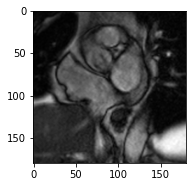

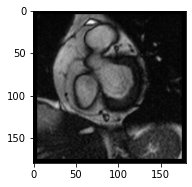

In [164]:
# Celda para comprobar que load_images funciona bien
%matplotlib inline
from IPython.display import clear_output
images = load_images(get_df_paths(n = 3)) 

for i in range (10):
    for j in range(2):
        plt.subplot(1,2,j+1)
        plt.imshow(images[j][:,:,i])
        plt.show()
    time.sleep(0.5)
    clear_output(wait=True)